In [1]:
from math import sqrt

import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import linprog

import metrics

In [2]:
def wasserstein_linear_program(x, y, cost_matrix):
    if x.ndim != 4 or y.ndim != 4:
        raise ValueError("Not an image")
    if x.shape != y.shape:
        raise ValueError("Given images of different shapes")
    
    # batch = x.shape[0]
    # channels = x.shape[1]
    width = x.shape[2]
    height = x.shape[3]

    x_vector = x.flatten()
    y_vector = y.flatten()
    x_vector = x_vector / x_vector.sum()
    y_vector = y_vector / y_vector.sum()

    n = width * height

    Ap, Aq = [], []
    z = np.zeros((n, n))
    z[:, 0] = 1

    for i in range(n):
        Ap.append(z.ravel())
        Aq.append(z.transpose().ravel())
        z = np.roll(z, 1, axis=1)

    A = np.row_stack((Ap, Aq))[:-1]
    b = np.concatenate((x_vector, y_vector))[:-1]

    result = linprog(cost_matrix.ravel(), A_eq=A, b_eq=b)
    return np.sum(result.x.reshape((n, n)) * cost_matrix.numpy())

In [18]:

def get_graph(regularization, dimension):
    width, height = dimension, dimension
    image_one = np.random.rand(width, height)
    image_two = np.random.rand(width, height)
    image_one /= np.sum(image_one)
    image_two /= np.sum(image_two)
    image_one = torch.tensor(image_one, dtype=torch.float32)
    image_two = torch.tensor(image_two, dtype=torch.float32)
    image_one, image_two = image_one.reshape(width * height), image_two.reshape(width * height)

    cost_matrix = torch.tensor(
            [
                [
                    abs(i // width - j // width) + abs(i % width - j % width) 
                    for j in range(width * height)
                ]
                for i in range(width * height)
            ]
        )

    wasserstein = metrics.WassersteinApproximation(regularization=regularization)
    return wasserstein.compute_vectors_distance(image_one, image_two, cost_matrix, True)

In [6]:
def get_graphs(regularizations, dimension):
    width, height = dimension, dimension
    image_one = np.random.rand(width, height)
    image_two = np.random.rand(width, height)
    image_one /= np.sum(image_one)
    image_two /= np.sum(image_two)
    image_one = torch.tensor(image_one, dtype=torch.float32)
    image_two = torch.tensor(image_two, dtype=torch.float32)
    image_one, image_two = image_one.reshape(width * height), image_two.reshape(width * height)

    cost_matrix = torch.tensor(
            [
                [
                    abs(i // width - j // width) + abs(i % width - j % width) 
                    for j in range(width * height)
                ]
                for i in range(width * height)
            ]
        )
    plots = []
    for regularization in regularizations:
        wasserstein = metrics.WassersteinApproximation(regularization=regularization, iterations=2000)
        plots.append(wasserstein.compute_vectors_distance(image_one, image_two, cost_matrix, True))
    if dimension < 25:    
        lin = wasserstein_linear_program(image_one.reshape(1, 1, width, height), image_two.reshape(1, 1, width, height), cost_matrix)
        plots.append([lin for _ in range(500)])
    return plots

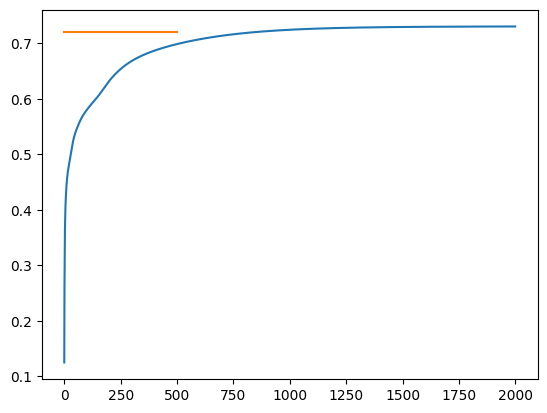

In [7]:
for plot in get_graphs([5], 20):
    plt.plot(plot)
plt.show()

In [3]:
def get_mnist_images_pairs(num):
    mnist = torchvision.datasets.MNIST('mnist', download=True, transform=torchvision.transforms.ToTensor())
    for i in range(num):
        yield mnist[i][0].unsqueeze(0), mnist[i + 1][0].unsqueeze(0)

In [4]:
def get_graphs_for_more_mnist_images(regularization, num):
    width, height = 28, 28
    cost_matrix = torch.tensor(
            [
                [
                    abs(i // width - j // width) + abs(i % width - j % width) 
                    for j in range(width * height)
                ]
                for i in range(width * height)
            ]
        )
    plots = []
    wasserstein = metrics.WassersteinApproximation(regularization=regularization, iterations=250)

    for image_one, image_two in get_mnist_images_pairs(num):
        plots.append(wasserstein.compute_vectors_distance(
            image_one.flatten() / image_one.sum(),
            image_two.flatten() / image_two.sum(),
            cost_matrix,
            True)
        )
    return plots

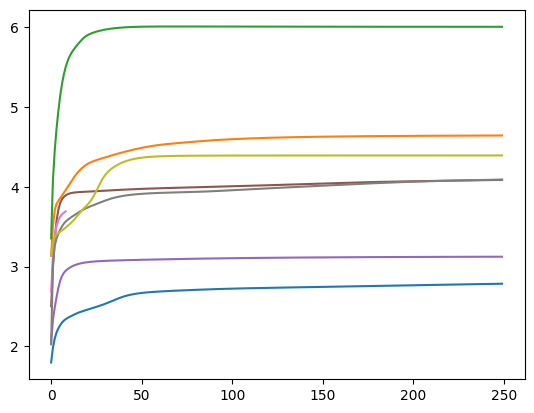

In [5]:
for plot in get_graphs_for_more_mnist_images(5, 10):
    plt.plot(plot)
plt.show()

## Outline

- For MNIST purposes, regularization 5 is enough as well as 250 to be the number of iterations

## Differentiation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, torchvision

import metrics

c:\Users\stani\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_mnist_image_batch(num):
    mnist = torchvision.datasets.MNIST('mnist', download=True, transform=torchvision.transforms.ToTensor())
    ims = torch.zeros(num, 1, 28, 28)
    for i in range(num):
        ims[i, ...] = mnist[i][0]
    return ims

In [3]:
dim = 28

image_prime = torch.rand(1, 1, dim, dim)
image_prime.requires_grad = True
image_tilde = torch.rand(1, 1, dim, dim)

wass = metrics.WassersteinApproximation(debug=True)

dist = wass(image_prime, image_tilde)
print(dist)
print("___")
dist.backward()
print(image_prime.grad)

tensor([0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 

In [13]:
mnist_batch = get_mnist_image_batch(5)
mnist_batch.requires_grad = True
# print(mnist_batch.shape)
wass = metrics.WassersteinApproximation(iterations=2, debug=True)
dist = wass(mnist_batch, mnist_batch +1e-3 * torch.rand_like(mnist_batch))
print(dist)
print("___")
dist[dist == dist].sum().backward()


u_vector: min=0.0060240961611270905, mean=0.006024095695465803, max=0.0060240961611270905
K_matrix: min=9.999999747378752e-06, mean=0.0013203555718064308, max=1.0000100135803223
K_tilde: min=0.0010794117115437984, mean=1.295133113861084, max=27525.2734375
tensor([[1.0000e-05, 1.0000e-05, 1.0000e-05,  ..., 1.0000e-05, 1.0000e-05,
         1.0000e-05],
        [1.0000e-05, 1.0000e-05, 1.0000e-05,  ..., 1.0000e-05, 1.0000e-05,
         1.0000e-05],
        [1.0000e-05, 1.0000e-05, 1.0000e-05,  ..., 1.0000e-05, 1.0000e-05,
         1.0000e-05],
        ...,
        [1.0000e-05, 1.0000e-05, 1.0000e-05,  ..., 1.0000e-05, 1.0000e-05,
         1.0000e-05],
        [1.0000e-05, 1.0000e-05, 1.0000e-05,  ..., 1.0000e-05, 1.0000e-05,
         1.0000e-05],
        [1.0000e-05, 1.0000e-05, 1.0000e-05,  ..., 1.0000e-05, 1.0000e-05,
         1.0000e-05]])
tensor([1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
        1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 